In [25]:

import rasterio
import numpy as np
import json
import pandas as pd
from PIL import ImageColor
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines # Necesario para la leyenda de marcadores
from skimage import measure # Necesario para encontrar componentes conectados y contornos
from skimage.draw import polygon as draw_polygon # Necesario para dibujar el polígono en una máscara

# --- Configuración de rutas de archivos ---
# Directorio del archivo JSON con la leyenda de clases
lc_dir = 'data/7Labels.json' # Asegúrate de que esta ruta sea correcta

# Ruta de la imagen TIFF segmentada
segmented_image_path = 'D3_029.tif' # Asegúrate de que esta ruta sea correcta


In [26]:
# Celda 2: Carga de Leyenda de Clases

# Cargar la leyenda de clases desde el archivo JSON
try:
    with open(lc_dir, 'r') as f:
        lc = json.load(f)
except FileNotFoundError:
    print(f"Error: El archivo de leyenda '{lc_dir}' no se encontró")
    exit()

lc_df = pd.DataFrame(lc)
lc_df["values_normalize"] = lc_df.index
lc_df["palette"] = "#" + lc_df["palette"]

# Mapeo de nombres de clase a valores numéricos normalizados
class_to_value = lc_df.set_index('label')['values_normalize'].to_dict()

# Crear el mapa de colores para la visualización (opcional, pero útil para mostrar la imagen)
colors_for_cmap = lc_df["palette"].to_list()
labels_for_legend = lc_df["label"].to_list()
cmap = ListedColormap(colors_for_cmap)
patches = [mpatches.Patch(color=colors_for_cmap[i], label=labels_for_legend[i]) for i in range(len(labels_for_legend))]

print("Leyenda de clases cargada y procesada.")
print("\nClases disponibles para búsqueda:")
for label, value in class_to_value.items():
    print(f"- {label} (Valor normalizado: {value})")

Leyenda de clases cargada y procesada.

Clases disponibles para búsqueda:
- Arboles (Valor normalizado: 0)
- Sotobosque (Valor normalizado: 1)
- Tierra (Valor normalizado: 2)
- Infraestructura (Valor normalizado: 3)
- Sombra (Valor normalizado: 4)
- Agua (Valor normalizado: 5)
- No Clasificado (Valor normalizado: 6)


In [27]:
try:
    src = rasterio.open(segmented_image_path)
    segmented_data = src.read(1) # Leer la primera (y única) banda de la imagen segmentada
    transform = src.transform # Matriz de transformación georreferenciada
    print(transform)
    crs = src.crs # Sistema de coordenadas de referencia
    bounds = src.bounds # Límites geográficos de la imagen
    pixel_width_m = abs(transform.a) # Resolución en metros por píxel (ancho)
    pixel_height_m = abs(transform.e) # Resolución en metros por píxel (alto)
    print(f"Imagen segmentada '{segmented_image_path}' cargada exitosamente.")
    print(f"Dimensiones de la imagen: {segmented_data.shape[0]} filas x {segmented_data.shape[1]} columnas")
    print(f"Resolución del píxel: {pixel_width_m:.2f}m x {pixel_height_m:.2f}m")
except rasterio.RasterioIOError:
    print(f"Error: No se pudo abrir la imagen segmentada '{segmented_image_path}'")
    exit()
except Exception as e:
    print(f"Ocurrió un error al cargar la imagen: {e}")
    exit()


| 0.10, 0.00, 232111.05|
| 0.00,-0.10, 5075927.06|
| 0.00, 0.00, 1.00|
Imagen segmentada 'D3_029.tif' cargada exitosamente.
Dimensiones de la imagen: 1751 filas x 3014 columnas
Resolución del píxel: 0.10m x 0.10m


In [28]:
# Celda 4: Funciones para Conversión de Coordenadas y Análisis

from pyproj import Transformer, CRS # Importar CRS y Transformer aquí para asegurar su disponibilidad
from skimage import measure # Necesario para encontrar componentes conectados y contornos
from skimage.draw import polygon as draw_polygon # Necesario para dibujar el polígono en una máscara

def world_to_pixel(lon, lat, transform):
    """
    Convierte coordenadas geográficas (longitud, latitud) a coordenadas de píxel (fila, columna).
    Retorna (fila, columna).
    """
    col, row = ~transform * (lon, lat)
    # Redondear al píxel más cercano
    return int(row + 0.5), int(col + 0.5)

def check_class_presence_in_polygon(
    polygon_coords_world_input, # Lista de tuplas (lon, lat) en el orden secuencial de entrada
    input_crs_str, # CRS de las coordenadas de entrada (ej. 'EPSG:4326')
    target_class_name, min_pixels_threshold,
    segmented_data, transform, image_crs, class_to_value, # image_crs
    image_shape # (rows, cols)
):
    """
    Analiza la presencia de una clase específica dentro de un polígono definido por coordenadas geográficas,
    buscando *todas* las agrupaciones de píxeles contiguos que estén por encima del umbral.
    Realiza transformación de CRS si es necesario.

    Args:
        polygon_coords_world_input (list): Lista de tuplas (lon, lat) que definen los vértices del polígono
                                           en el CRS de entrada.
        input_crs_str (str): Cadena del CRS de las coordenadas de entrada (ej., 'EPSG:4326').
        target_class_name (str): Nombre de la clase a buscar (ej. 'Vegetación Alta').
        min_pixels_threshold (int): Número mínimo de píxeles contiguos de la clase objetivo para considerar una agrupación.
        segmented_data (np.ndarray): Array 2D de la imagen segmentada.
        transform (rasterio.Affine): Objeto de transformación georreferenciada de la imagen.
        image_crs (rasterio.crs.CRS): Objeto CRS de la imagen segmentada.
        class_to_value (dict): Diccionario que mapea nombres de clase a sus valores numéricos.
        image_shape (tuple): Tupla (altura, anchura) de la imagen segmentada.

    Returns:
        tuple: (bool, int, tuple, tuple, list, np.ndarray) - (presencia_detectada, tamaño_mayor_agrupacion,
               (row_start, col_start, row_end, col_end), (center_row_vis, center_col_vis),
               lista_de_mascaras_de_agrupaciones_validas_relativas_a_subset, polygon_coords_pixel_relative_to_subset)
               Retorna None para las coordenadas y máscaras si el polígono no es válido o no se encuentra la clase.
    """
    target_value = class_to_value.get(target_class_name)
    if target_value is None:
        print(f"Advertencia: La clase '{target_class_name}' no se encontró en la leyenda. Asegúrate de que el nombre coincide exactamente con las clases disponibles.")
        return False, 0, None, None, [], None

    # --- Transformar coordenadas de entrada al CRS de la imagen ---
    input_crs = CRS(input_crs_str)
    
    # Si el CRS de entrada es diferente al CRS de la imagen, transformar
    if input_crs != image_crs:
        transformer = Transformer.from_crs(input_crs, image_crs, always_xy=True) # always_xy=True para (lon, lat)
        polygon_coords_image_crs = [transformer.transform(lon, lat) for lon, lat in polygon_coords_world_input]
        print(f"Coordenadas transformadas de {input_crs_str} a {image_crs.to_string()}")
    else:
        polygon_coords_image_crs = polygon_coords_world_input
        print(f"CRS de entrada ({input_crs_str}) coincide con CRS de la imagen. No se necesita transformación.")

    # Convertir las coordenadas del polígono (ahora en CRS de la imagen) a píxeles
    polygon_coords_pixel = np.array([world_to_pixel(lon, lat, transform) for lon, lat in polygon_coords_image_crs])
    
    # Extraer filas y columnas para calcular el bounding box del polígono en píxeles
    rows_px = polygon_coords_pixel[:, 0]
    cols_px = polygon_coords_pixel[:, 1]

    # Calcular el bounding box (rectángulo delimitador) en píxeles
    row_start = max(0, np.min(rows_px))
    row_end = min(image_shape[0], np.max(rows_px) + 1) # +1 para incluir el último píxel
    col_start = max(0, np.min(cols_px))
    col_end = min(image_shape[1], np.max(cols_px) + 1) # +1 para incluir el último píxel

    # Calcular el centro del bounding box en píxeles para la visualización
    center_row_vis = int((row_start + row_end) / 2)
    center_col_vis = int((col_start + col_end) / 2)

    # Asegurarse de que el bounding box sea válido
    if row_start >= row_end or col_start >= col_end:
        print(f"Advertencia: El polígono definido está fuera de los límites de la imagen o es demasiado pequeño.")
        return False, 0, None, None, [], None

    # Extraer la sub-región de la imagen segmentada basada en el bounding box del polígono
    subset_data = segmented_data[row_start:row_end, col_start:col_end]
    
    # Crear una máscara binaria del polígono dentro de la sub-región
    # Las coordenadas del polígono deben ser relativas a la sub-región
    polygon_coords_pixel_relative_to_subset = polygon_coords_pixel - np.array([row_start, col_start])

    # Crear una máscara vacía del tamaño de la sub-región
    polygon_mask_subset = np.zeros(subset_data.shape, dtype=bool)
    
    # Dibujar el polígono en la máscara
    rr, cc = draw_polygon(polygon_coords_pixel_relative_to_subset[:, 0], # filas
                          polygon_coords_pixel_relative_to_subset[:, 1], # columnas
                          shape=polygon_mask_subset.shape)
    polygon_mask_subset[rr, cc] = True

    # Crear una máscara binaria para la clase objetivo dentro de la sub-región
    target_class_mask_subset = (subset_data == target_value)
    
    # Combinar la máscara de la clase objetivo con la máscara del polígono de entrada
    # Esto asegura que solo contamos píxeles de la clase objetivo *dentro* del polígono definido
    final_analysis_mask = target_class_mask_subset & polygon_mask_subset

    # Encontrar agrupaciones de píxeles contiguos (componentes conectados)
    labeled_mask = measure.label(final_analysis_mask, connectivity=2) # connectivity=2 para 8-conectividad
    
    # Analizar el tamaño de cada agrupación y recolectar las que cumplen el umbral
    largest_blob_size = 0
    all_valid_blobs_masks_relative_to_subset = [] # Lista para almacenar todas las máscaras que cumplen el umbral

    for label_id in np.unique(labeled_mask):
        if label_id == 0: # 0 es el fondo
            continue
        
        current_blob_mask = (labeled_mask == label_id)
        current_blob_size = np.sum(current_blob_mask)
        
        if current_blob_size >= min_pixels_threshold:
            all_valid_blobs_masks_relative_to_subset.append(current_blob_mask)
            if current_blob_size > largest_blob_size:
                largest_blob_size = current_blob_size
    
    is_present = len(all_valid_blobs_masks_relative_to_subset) > 0 # Si encontramos al menos una agrupación que cumple el umbral

    # Devolver el resultado
    return is_present, largest_blob_size, (row_start, col_start, row_end, col_end), \
           (center_row_vis, center_col_vis), all_valid_blobs_masks_relative_to_subset, \
           polygon_coords_pixel_relative_to_subset # Devolver las coordenadas del polígono de entrada ya relativas


In [29]:
# Celda 5: Entrada de Usuario y Ejecución del Análisis
def parse_polygon_coords_input(coords_str):
    polygon_points = []
    # Dividir la cadena por comas para obtener cada par de coordenadas
    point_strs = coords_str.split(',')
    
    if len(point_strs) != 4:
        raise ValueError("Se espera un polígono cuadrilatero. Formato: 'lon1 lat1, lon2 lat2, lon3 lat3, lon4 lat4'")

    for p_str in point_strs:
        try:
            # Reemplazar coma por punto para decimales y luego dividir por espacio
            clean_p_str = p_str.strip().replace(',', '.') 
            lon_str, lat_str = clean_p_str.split()
            lon = float(lon_str)
            lat = float(lat_str)
            polygon_points.append((lon, lat))
        except ValueError:
            raise ValueError(f"Formato de punto inválido: '{p_str}'. Esperado 'lon lat'.")
    return polygon_points

# --- Entrada de usuario ---
print("\n--- Por favor, introduce los parámetros para el análisis ---")

# Seleccionar la clase a buscar
while True:
    target_class_name_input = input("Introduce el nombre exacto de la clase a buscar (ej. 'Arboles', 'Infraestructura): ").strip()
    if target_class_name_input in class_to_value:
        example_target_class_name = target_class_name_input
        break
    else:
        print(f"'{target_class_name_input}' no es una clase válida.")

#Coordenadas del polígono deseado 
while True:
    print("\nIntroduce las 4 coordenadas del polígono en orden secuencial (en sentido horario).")
    print("Google Earth Engine: el CRS es 'EPSG:4326'")
    print("QGIS: el CRS es 'EPSG:3857'")
    coords_str = input("Formato: 'Lon1 Lat1, Lon2 Lat2, Lon3 Lat3, Lon4 Lat4': ").strip()
    try:
        example_polygon_coords_world = parse_polygon_coords_input(coords_str)
        if len(example_polygon_coords_world) != 4:
            raise ValueError("Revisa el formato de coordenadas")
        break
    except ValueError as e:
        print(f"Error en el formato: {e}. Inténtalo de nuevo.")
    except Exception as e:
        print(f"Error inesperado: {e}. Inténtalo de nuevo.")

# Preguntar el CRS
while True:
    input_crs_for_analysis = input("Introduce el CRS de tus coordenadas de entrada (ej. 'EPSG:4326' para GEE, 'EPSG:3857' para QGIS): ").strip().upper()
    if input_crs_for_analysis in ['EPSG:4326', 'EPSG:3857', src.crs.to_string().upper()]: 
        break
    else:
        print(f"CRS '{input_crs_for_analysis}' no reconocido o soportado. ")

#Definir el número umbral de píxeles
while True:
    try:
        min_pixels_input = input("Introduce el umbral mínimo de píxeles (): ").strip()
        example_min_pixels_threshold = int(min_pixels_input)
        if example_min_pixels_threshold < 1:
            raise ValueError("El umbral debe ser un número entero positivo mayor que 1.")
        break
    except ValueError as e:
        print(f"Entrada inválida: {e}.")

print(f"\n--- Analizando presencia de agrupaciones de '{example_target_class_name}' en el polígono ---")
print(f"Polígono de entrada: {example_polygon_coords_world} (CRS: {input_crs_for_analysis})")
print(f"Umbral mínimo de píxeles: {example_min_pixels_threshold}")


is_present, largest_blob_size, rect_coords_pixels, center_coords_vis, all_valid_blobs_masks, polygon_coords_pixel_relative_to_subset = check_class_presence_in_polygon(
    example_polygon_coords_world,
    input_crs_for_analysis, # Pasa el CRS de entrada
    example_target_class_name, example_min_pixels_threshold,
    segmented_data, transform, crs, class_to_value, # Pasa el CRS de la imagen (src.crs)
    segmented_data.shape
)

if is_present:
    num_blobs_found = len(all_valid_blobs_masks)
    print(f"\n¡Presencia detectada! Se encontraron {num_blobs_found} agrupaciones de '{example_target_class_name}' por encima del umbral de {example_min_pixels_threshold} píxeles.")
    if num_blobs_found > 0:
        print(f"La agrupación más grande encontrada tiene {largest_blob_size} píxeles contiguos.")
else:
    print(f"\nNo se detectó ninguna agrupación significativa de '{example_target_class_name}' (mayor o igual a {example_min_pixels_threshold} píxeles contiguos). La agrupación más grande encontrada fue de {largest_blob_size} píxeles.")

if center_coords_vis:
    center_row_vis, center_col_vis = center_coords_vis
else:
    center_row_vis, center_col_vis = None, None 



--- Por favor, introduce los parámetros para el análisis ---

Introduce las 4 coordenadas del polígono en orden secuencial (en sentido horario).
Google Earth Engine: el CRS es 'EPSG:4326'
QGIS: el CRS es 'EPSG:3857'

--- Analizando presencia de agrupaciones de 'Arboles' en el polígono ---
Polígono de entrada: [(2.0853774159326965, 41.42944222774784), (2.0853237717523987, 41.42932156506002), (2.0856536834612305, 41.42921095739919), (2.085715374268573, 41.42929542144811)] (CRS: EPSG:4326)
Umbral mínimo de píxeles: 5000
Coordenadas transformadas de EPSG:4326 a EPSG:3857

¡Presencia detectada! Se encontraron 1 agrupaciones de 'Arboles' por encima del umbral de 5000 píxeles.
La agrupación más grande encontrada tiene 14336 píxeles contiguos.


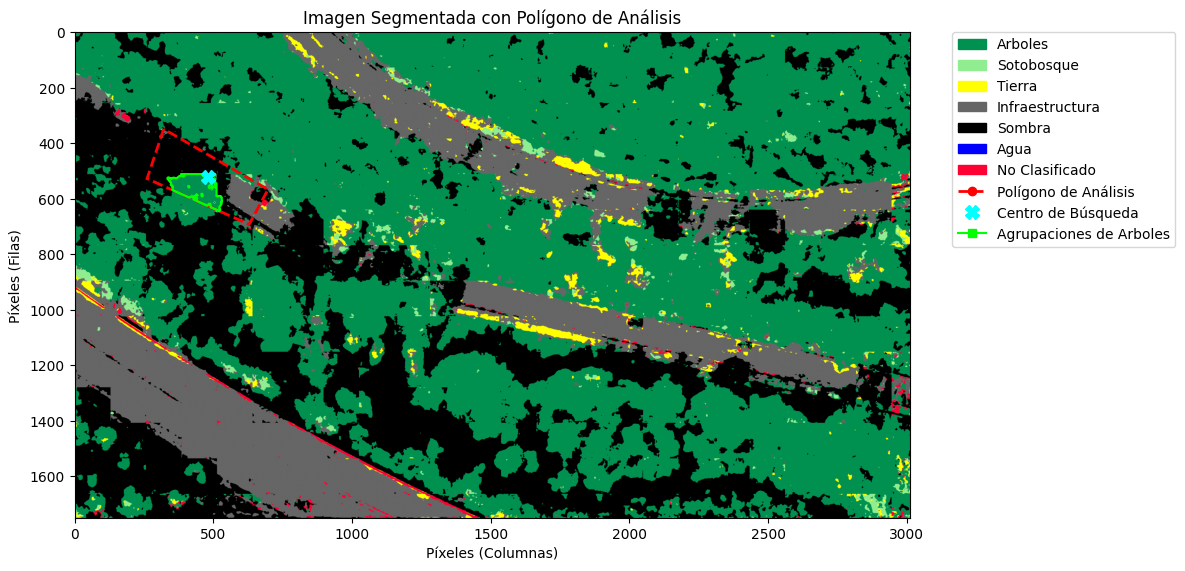

Visualización de la imagen completa completada y archivo de imagen cerrado.


In [30]:
# Celda 6: Visualización de la Imagen Completa con Polígono de Análisis

plt.figure(figsize=(12, 10))
ax = plt.imshow(segmented_data, cmap=cmap, vmin=0, vmax=len(colors_for_cmap) - 1)
plt.title(f'Imagen Segmentada con Polígono de Análisis')
plt.xlabel('Píxeles (Columnas)')
plt.ylabel('Píxeles (Filas)')

legend_handles = list(patches)

# Dibujar el polígono de entrada si se calculó
if 'polygon_coords_pixel_relative_to_subset' in locals() and polygon_coords_pixel_relative_to_subset is not None:
    # Convertir las coordenadas relativas del polígono a coordenadas absolutas de la imagen completa
    # Necesitamos las coordenadas absolutas del bounding box (rect_coords_pixels)
    if rect_coords_pixels:
        row_start, col_start, _, _ = rect_coords_pixels
        polygon_coords_abs = polygon_coords_pixel_relative_to_subset + np.array([row_start, col_start])
        
        # Crear y añadir el polígono de entrada
        # Matplotlib Polygon espera (col, row)
        input_polygon_patch = mpatches.Polygon(
            polygon_coords_abs[:, ::-1], # Invertir a (col, row) para Matplotlib
            closed=True,
            edgecolor='red' if is_present else 'blue', # Rojo si hay presencia, azul si no
            facecolor='none',
            linewidth=2,
            linestyle='--'
        )
        ax.axes.add_patch(input_polygon_patch)
        
        # Añadir entrada a la leyenda para el polígono de entrada
        input_polygon_legend_patch = mlines.Line2D(
            [], [],
            color='red' if is_present else 'blue',
            marker='o', # Marcador para el polígono de entrada
            linestyle='--',
            linewidth=2,
            label='Polígono de Análisis'
        )
        legend_handles.append(input_polygon_legend_patch)

    # Añadir el marcador del centro de búsqueda si las coordenadas son válidas
    if center_row_vis is not None and center_col_vis is not None:
        plt.plot(center_col_vis, center_row_vis, 'X', color='cyan', markersize=10)
        center_marker_legend = mlines.Line2D(
            [], [],
            color='cyan',
            marker='X',
            linestyle='None',
            markersize=10,
            label='Centro de Búsqueda'
        )
        legend_handles.append(center_marker_legend)

    # Dibujar *todas* las agrupaciones de píxeles detectadas (si hay presencia)
    if is_present and 'all_valid_blobs_masks' in locals() and all_valid_blobs_masks:
        row_start, col_start, _, _ = rect_coords_pixels # Asegurarse de tener el offset
        
        for blob_mask in all_valid_blobs_masks:
            contours = measure.find_contours(blob_mask, level=0.5)
            for contour in contours:
                # Convertir coordenadas del contorno de relativas a la sub-imagen a absolutas
                polygon_coords_x_abs = contour[:, 1] + col_start
                polygon_coords_y_abs = contour[:, 0] + row_start
                
                polygon_blob = mpatches.Polygon(
                    np.column_stack([polygon_coords_x_abs, polygon_coords_y_abs]),
                    closed=True,
                    edgecolor='lime', # Color verde brillante para los polígonos de las agrupaciones
                    facecolor='none',
                    linewidth=1.5,
                    linestyle='-'
                )
                ax.axes.add_patch(polygon_blob)
        
        # Añadir UNA entrada a la leyenda para todas las agrupaciones
        polygon_blob_legend_patch = mlines.Line2D(
            [], [],
            color='lime',
            marker='s',
            linestyle='-',
            linewidth=1.5,
            label=f'Agrupaciones de {example_target_class_name}'
        )
        legend_handles.append(polygon_blob_legend_patch)

plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

# Cerrar el dataset de rasterio
src.close()
print("Visualización de la imagen completa completada y archivo de imagen cerrado.")


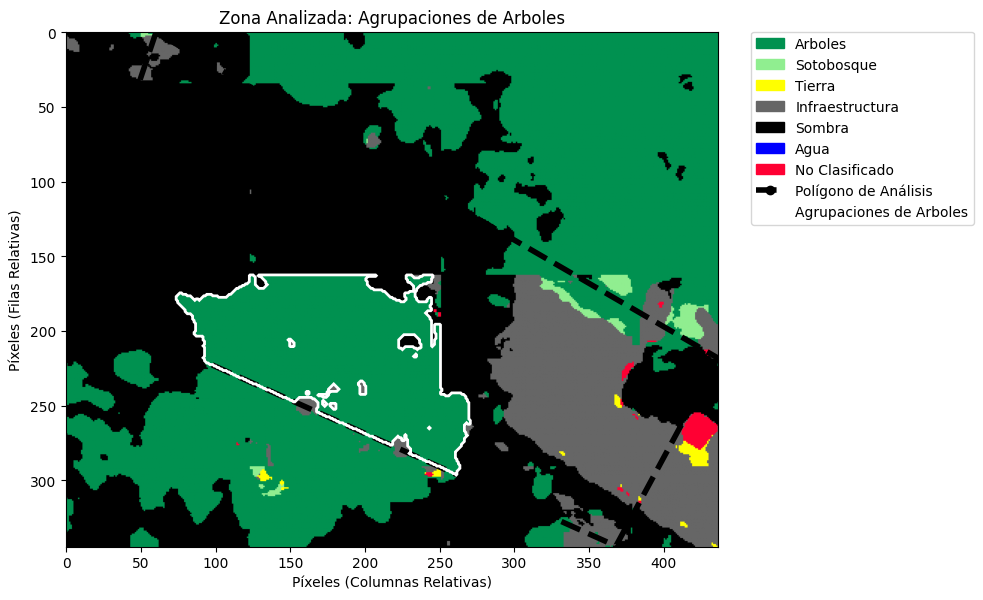

Visualización de la zona delimitada completada.


In [31]:
# Celda 7: Visualización de la Zona Delimitada con Polígono

# Asegurarse de que rect_coords_pixels, is_present, all_valid_blobs_masks estén definidos y sean válidos
if 'rect_coords_pixels' not in locals() or rect_coords_pixels is None:
    print("Error: No se pudo obtener la zona delimitada. Ejecuta las celdas anteriores primero y asegúrate de que el polígono sea válido.")
else:
    row_start, col_start, row_end, col_end = rect_coords_pixels

    # Extraer la sub-imagen delimitada (bounding box del polígono de entrada)
    zoomed_image_data = segmented_data[row_start:row_end, col_start:col_end]

    plt.figure(figsize=(10, 8)) # Ajustar tamaño para la vista ampliada
    ax_zoom = plt.imshow(zoomed_image_data, cmap=cmap, vmin=0, vmax=len(colors_for_cmap) - 1)
    plt.title(f'Zona Analizada: Agrupaciones de {example_target_class_name}')
    plt.xlabel('Píxeles (Columnas Relativas)')
    plt.ylabel('Píxeles (Filas Relativas)')

    # Crear la leyenda para esta vista
    legend_handles_zoom = list(patches)
    
    # --- Dibujar el polígono de entrada en la vista ampliada ---
    if 'polygon_coords_pixel_relative_to_subset' in locals() and polygon_coords_pixel_relative_to_subset is not None:
        input_polygon_patch_zoom = mpatches.Polygon(
            polygon_coords_pixel_relative_to_subset[:, ::-1], # Invertir a (col, row)
            closed=True,
            edgecolor='black' if is_present else 'blue',
            facecolor='none',
            linewidth=4,
            linestyle='--'
        )
        ax_zoom.axes.add_patch(input_polygon_patch_zoom)
        input_polygon_legend_patch_zoom = mlines.Line2D(
            [], [],
            color='black' if is_present else 'blue',
            marker='o',
            linestyle='--',
            linewidth=4,
            label='Polígono de Análisis'
        )
        legend_handles_zoom.append(input_polygon_legend_patch_zoom)

    # --- Dibujar *todas* las agrupaciones de píxeles detectadas (si hay presencia) ---
    if is_present and 'all_valid_blobs_masks' in locals() and all_valid_blobs_masks:
        for blob_mask in all_valid_blobs_masks:
            # Encontrar contornos en la máscara binaria de la agrupación (ya relativa a la sub-región)
            contours_zoomed = measure.find_contours(blob_mask, level=0.5)
            
            # Dibujar cada contorno como un polígono
            for contour in contours_zoomed:
                # Los contornos ya están en coordenadas relativas a zoomed_image_data
                polygon_coords_x_zoom = contour[:, 1]
                polygon_coords_y_zoom = contour[:, 0]
                
                # Crear un polígono y añadirlo al gráfico
                polygon_zoom = mpatches.Polygon(
                    np.column_stack([polygon_coords_x_zoom, polygon_coords_y_zoom]),
                    closed=True,
                    edgecolor='white', # Color verde brillante para el polígono de la clase
                    facecolor='none',
                    linewidth=2, # Aumentar el grosor para mayor visibilidad
                    linestyle='-'
                )
                ax_zoom.axes.add_patch(polygon_zoom)
        
        # Añadir UNA entrada a la leyenda para todas las agrupaciones
        polygon_legend_patch_zoom = mlines.Line2D(
            [], [],
            color='white',
            marker='s', # Usar un marcador de cuadrado para el polígono
            linestyle='-',
            linewidth=1.5,
            label=f'Agrupaciones de {example_target_class_name}'
        )
        legend_handles_zoom.append(polygon_legend_patch_zoom)
    elif is_present:
        print(f"Advertencia: 'is_present' es True pero no se pudo dibujar el polígono de la agrupación. Esto puede ocurrir si el umbral es muy bajo y se detectan muchos píxeles dispersos, o si la máscara de la agrupación es vacía.")


    plt.legend(handles=legend_handles_zoom, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()

# No cerrar 'src' aquí, ya que podría necesitarse en otras celdas.
# src.close()
print("Visualización de la zona delimitada completada.")


In [32]:
# Celda 8: Resumen de Agrupaciones Detectadas

from scipy import ndimage # Necesario para calcular el centro de masa (centroide)

# Asegurarse de que all_valid_blobs_masks y rect_coords_pixels estén definidos y sean válidos
if 'all_valid_blobs_masks' not in locals() or not all_valid_blobs_masks:
    print("No se encontraron agrupaciones de píxeles que superen el umbral en la zona analizada.")
else:
    num_blobs = len(all_valid_blobs_masks)
    print(f"\n--- Resumen de las {num_blobs} agrupaciones de '{example_target_class_name}' detectadas ---")
    print(f"Umbral de píxeles contiguos: {example_min_pixels_threshold}")

    row_offset, col_offset, _, _ = rect_coords_pixels # Obtener el offset del bounding box

    for i, blob_mask in enumerate(all_valid_blobs_masks):
        blob_size = np.sum(blob_mask)
        
        # Calcular el centro de masa de la agrupación dentro de la máscara relativa
        # ndimage.center_of_mass devuelve (row_center, col_center)
        center_of_mass_relative = ndimage.center_of_mass(blob_mask)
        
        # Convertir el centro de masa relativo a coordenadas de píxel absolutas de la imagen
        center_row_abs = center_of_mass_relative[0] + row_offset
        center_col_abs = center_of_mass_relative[1] + col_offset
        
        print(f"\nAgrupación {i+1}:")
        print(f"  Tamaño: {blob_size} píxeles")
        print(f"  Coordenadas centrales (píxel absoluto): Fila {center_row_abs:.2f}, Columna {center_col_abs:.2f}")

        # Opcional: Convertir el centro de masa a coordenadas geográficas (lon, lat)
        # Esto requiere la transformación inversa del píxel a mundo
        center_lon_abs, center_lat_abs = src.transform * (center_col_abs, center_row_abs)
        print(f"  Coordenadas centrales (geográficas): Longitud {center_lon_abs:.6f}, Latitud {center_lat_abs:.6f}")

print("\nAnálisis de agrupaciones completado.")


--- Resumen de las 1 agrupaciones de 'Arboles' detectadas ---
Umbral de píxeles contiguos: 5000

Agrupación 1:
  Tamaño: 14336 píxeles
  Coordenadas centrales (píxel absoluto): Fila 565.29, Columna 443.87
  Coordenadas centrales (geográficas): Longitud 232155.437304, Latitud 5075870.530687

Análisis de agrupaciones completado.


In [33]:
# Celda 8: Resumen de Agrupaciones Detectadas

from scipy import ndimage # Necesario para calcular el centro de masa (centroide)
import pandas as pd # Necesario para guardar en CSV

# Asegurarse de que all_valid_blobs_masks y rect_coords_pixels estén definidos y sean válidos
if 'all_valid_blobs_masks' not in locals() or not all_valid_blobs_masks:
    print("No se encontraron agrupaciones de píxeles que superen el umbral en la zona analizada.")
    # Si no hay agrupaciones, no hay nada que guardar, así que podemos salir.
else:
    num_blobs = len(all_valid_blobs_masks)
    print(f"\n--- Resumen de las {num_blobs} agrupaciones de '{example_target_class_name}' detectadas ---")
    print(f"Umbral de píxeles contiguos: {example_min_pixels_threshold}")

    row_offset, col_offset, _, _ = rect_coords_pixels # Obtener el offset del bounding box

    # Lista para almacenar los datos de cada agrupación
    blob_data_for_csv = []

    for i, blob_mask in enumerate(all_valid_blobs_masks):
        blob_size = np.sum(blob_mask)
        
        # Calcular el centro de masa de la agrupación dentro de la máscara relativa
        # ndimage.center_of_mass devuelve (row_center, col_center)
        center_of_mass_relative = ndimage.center_of_mass(blob_mask)
        
        # Convertir el centro de masa relativo a coordenadas de píxel absolutas de la imagen
        center_row_abs = center_of_mass_relative[0] + row_offset
        center_col_abs = center_of_mass_relative[1] + col_offset
        
        # Convertir el centro de masa a coordenadas geográficas (lon, lat)
        # Esto requiere la transformación inversa del píxel a mundo
        center_lon_abs, center_lat_abs = src.transform * (center_col_abs, center_row_abs)
        
        print(f"\nAgrupación {i+1}:")
        print(f"  Tamaño: {blob_size} píxeles")
        print(f"  Coordenadas centrales (píxel absoluto): Fila {center_row_abs:.2f}, Columna {center_col_abs:.2f}")
        print(f"  Coordenadas centrales (geográficas): Longitud {center_lon_abs:.6f}, Latitud {center_lat_abs:.6f}")

        # Añadir los datos de la agrupación a la lista
        blob_data_for_csv.append({
            'ID_Agrupacion': i + 1,
            'Clase': example_target_class_name,
            'Tamaño_Pixeles': blob_size,
            'Centro_Fila_Pixel_Absoluto': round(center_row_abs, 2),
            'Centro_Columna_Pixel_Absoluto': round(center_col_abs, 2),
            'Centro_Longitud_Geografica': round(center_lon_abs, 6),
            'Centro_Latitud_Geografica': round(center_lat_abs, 6)
        })
    
    # --- Guardar los datos en un archivo CSV ---
    if blob_data_for_csv: # Solo guardar si hay datos
        df_blobs = pd.DataFrame(blob_data_for_csv)
        output_csv_filename = f"agrupaciones_{example_target_class_name.replace(' ', '_')}_umbral_{example_min_pixels_threshold}.csv"
        df_blobs.to_csv(output_csv_filename, index=False)
        print(f"\nDatos de las agrupaciones guardados en '{output_csv_filename}'")
    else:
        print("\nNo hay agrupaciones para guardar en CSV.")

print("\nAnálisis de agrupaciones completado.")



--- Resumen de las 1 agrupaciones de 'Arboles' detectadas ---
Umbral de píxeles contiguos: 5000

Agrupación 1:
  Tamaño: 14336 píxeles
  Coordenadas centrales (píxel absoluto): Fila 565.29, Columna 443.87
  Coordenadas centrales (geográficas): Longitud 232155.437304, Latitud 5075870.530687

Datos de las agrupaciones guardados en 'agrupaciones_Arboles_umbral_5000.csv'

Análisis de agrupaciones completado.



--- Resumen de las 1 agrupaciones de 'Arboles' detectadas ---
Umbral de píxeles contiguos: 5000

Agrupación 1:
  Tamaño: 14336 píxeles
  Coordenadas centrales: Fila 565.29, Columna 443.87
  Coordenadas centrales (geográficas): Longitud 232155.437304, Latitud 5075870.530687

Datos de las agrupaciones guardados en 'agrupaciones_Arboles_umbral_5000.csv'


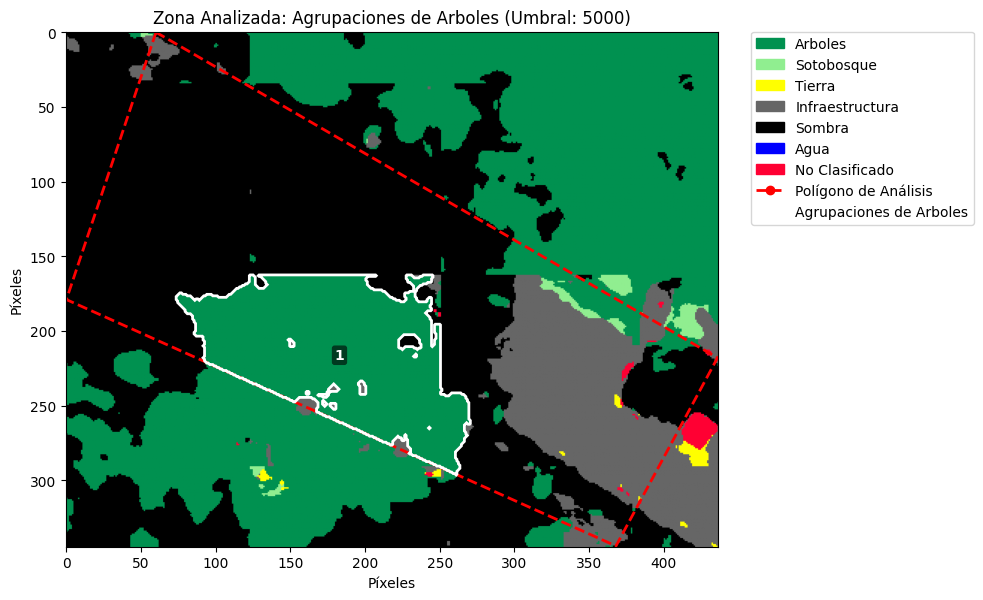


Análisis de agrupaciones completado.


In [34]:
# Celda 8: Resumen y Visualización de Agrupaciones Detectadas

from scipy import ndimage # Necesario para calcular el centro de masa (centroide)
import pandas as pd # Necesario para guardar en CSV
import matplotlib.pyplot as plt # Necesario para la visualización
import matplotlib.patches as mpatches # Necesario para dibujar polígonos
import matplotlib.lines as mlines # Necesario para la leyenda de marcadores
from skimage import measure # Necesario para encontrar contornos

# Asegurarse de que all_valid_blobs_masks y rect_coords_pixels estén definidos y sean válidos
if 'all_valid_blobs_masks' not in locals() or not all_valid_blobs_masks:
    print("No se encontraron agrupaciones de píxeles que superen el umbral en la zona analizada.")
    # Si no hay agrupaciones, no hay nada que guardar ni visualizar, así que podemos salir.
else:
    num_blobs = len(all_valid_blobs_masks)
    print(f"\n--- Resumen de las {num_blobs} agrupaciones de '{example_target_class_name}' detectadas ---")
    print(f"Umbral de píxeles contiguos: {example_min_pixels_threshold}")

    row_offset, col_offset, _, _ = rect_coords_pixels # Obtener el offset del bounding box

    # Lista para almacenar los datos de cada agrupación
    blob_data_for_csv = []

    for i, blob_mask in enumerate(all_valid_blobs_masks):
        blob_size = np.sum(blob_mask)
        
        # Calcular el centro de masa de la agrupación dentro de la máscara relativa
        # ndimage.center_of_mass devuelve (row_center, col_center)
        center_of_mass_relative = ndimage.center_of_mass(blob_mask)
        
        # Convertir el centro de masa relativo a coordenadas de píxel absolutas de la imagen
        center_row_abs = center_of_mass_relative[0] + row_offset
        center_col_abs = center_of_mass_relative[1] + col_offset
        
        # Convertir el centro de masa a coordenadas geográficas (lon, lat)
        # Esto requiere la transformación inversa del píxel a mundo
        center_lon_abs, center_lat_abs = src.transform * (center_col_abs, center_row_abs)
        
        print(f"\nAgrupación {i+1}:")
        print(f"  Tamaño: {blob_size} píxeles")
        print(f"  Coordenadas centrales: Fila {center_row_abs:.2f}, Columna {center_col_abs:.2f}")
        print(f"  Coordenadas centrales (geográficas): Longitud {center_lon_abs:.6f}, Latitud {center_lat_abs:.6f}")

        # Añadir los datos de la agrupación a la lista
        blob_data_for_csv.append({
            'ID_Agrupacion': i + 1,
            'Clase': example_target_class_name,
            'Tamaño_Pixeles': blob_size,
            'Centro_Fila_Pixel_Absoluto': round(center_row_abs, 2),
            'Centro_Columna_Pixel_Absoluto': round(center_col_abs, 2),
            'Centro_Longitud_Geografica': round(center_lon_abs, 6),
            'Centro_Latitud_Geografica': round(center_lat_abs, 6)
        })
    
    # --- Guardar los datos en un archivo CSV ---
    if blob_data_for_csv: # Solo guardar si hay datos
        df_blobs = pd.DataFrame(blob_data_for_csv)
        output_csv_filename = f"agrupaciones_{example_target_class_name.replace(' ', '_')}_umbral_{example_min_pixels_threshold}.csv"
        df_blobs.to_csv(output_csv_filename, index=False)
        print(f"\nDatos de las agrupaciones guardados en '{output_csv_filename}'")
    else:
        print("\nNo hay agrupaciones para guardar en CSV.")

    if 'rect_coords_pixels' in locals() and rect_coords_pixels is not None:
        row_start, col_start, row_end, col_end = rect_coords_pixels

        # Extraer la sub-imagen delimitada (bounding box del polígono de entrada)
        zoomed_image_data = segmented_data[row_start:row_end, col_start:col_end]

        plt.figure(figsize=(10, 8)) # Ajustar tamaño para la vista ampliada
        ax_zoom = plt.imshow(zoomed_image_data, cmap=cmap, vmin=0, vmax=len(colors_for_cmap) - 1)
        plt.title(f'Zona Analizada: Agrupaciones de {example_target_class_name} (Umbral: {example_min_pixels_threshold})')
        plt.xlabel('Píxeles')
        plt.ylabel('Píxeles')

        legend_handles_zoom = list(patches)
        
        # --- Dibujar el polígono de entrada en la vista ampliada ---
        if 'polygon_coords_pixel_relative_to_subset' in locals() and polygon_coords_pixel_relative_to_subset is not None:
            input_polygon_patch_zoom = mpatches.Polygon(
                polygon_coords_pixel_relative_to_subset[:, ::-1], # Invertir a (col, row)
                closed=True,
                edgecolor='red' if is_present else 'blue',
                facecolor='none',
                linewidth=2,
                linestyle='--'
            )
            ax_zoom.axes.add_patch(input_polygon_patch_zoom)
            input_polygon_legend_patch_zoom = mlines.Line2D(
                [], [],
                color='red' if is_present else 'blue',
                marker='o',
                linestyle='--',
                linewidth=2,
                label='Polígono de Análisis'
            )
            legend_handles_zoom.append(input_polygon_legend_patch_zoom)

        
        if all_valid_blobs_masks:
            for i, blob_mask in enumerate(all_valid_blobs_masks):
                contours_zoomed = measure.find_contours(blob_mask, level=0.5)
                
                # Calcular el centroide para el texto
                center_of_mass_relative = ndimage.center_of_mass(blob_mask)
                text_y, text_x = center_of_mass_relative[0], center_of_mass_relative[1]
                
                # Dibujar cada contorno como un polígono
                for contour in contours_zoomed:
                    polygon_coords_x_zoom = contour[:, 1]
                    polygon_coords_y_zoom = contour[:, 0]
                    
                    polygon_zoom = mpatches.Polygon(
                        np.column_stack([polygon_coords_x_zoom, polygon_coords_y_zoom]),
                        closed=True,
                        edgecolor='white', # Color verde brillante para el polígono de la clase
                        facecolor='none',
                        linewidth=2,
                        linestyle='-'
                    )
                    ax_zoom.axes.add_patch(polygon_zoom)
                
                # Añadir el número de la agrupación
                ax_zoom.axes.text( # MODIFICACIÓN AQUÍ: ax_zoom.axes.text()
                    text_x, text_y, str(i + 1),
                    color='white', # Color del texto
                    fontsize=10,
                    fontweight='bold',
                    ha='center', # Alineación horizontal
                    va='center', # Alineación vertical
                    bbox=dict(facecolor='black', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2')
                )
            
            #Leyenda
            polygon_legend_patch_zoom = mlines.Line2D(
                [], [],
                color='white',
                marker='s',
                linestyle='-',
                linewidth=1.5,
                label=f'Agrupaciones de {example_target_class_name}'
            )
            legend_handles_zoom.append(polygon_legend_patch_zoom)

plt.legend(handles=legend_handles_zoom, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

print("\nAnálisis de agrupaciones completado.")


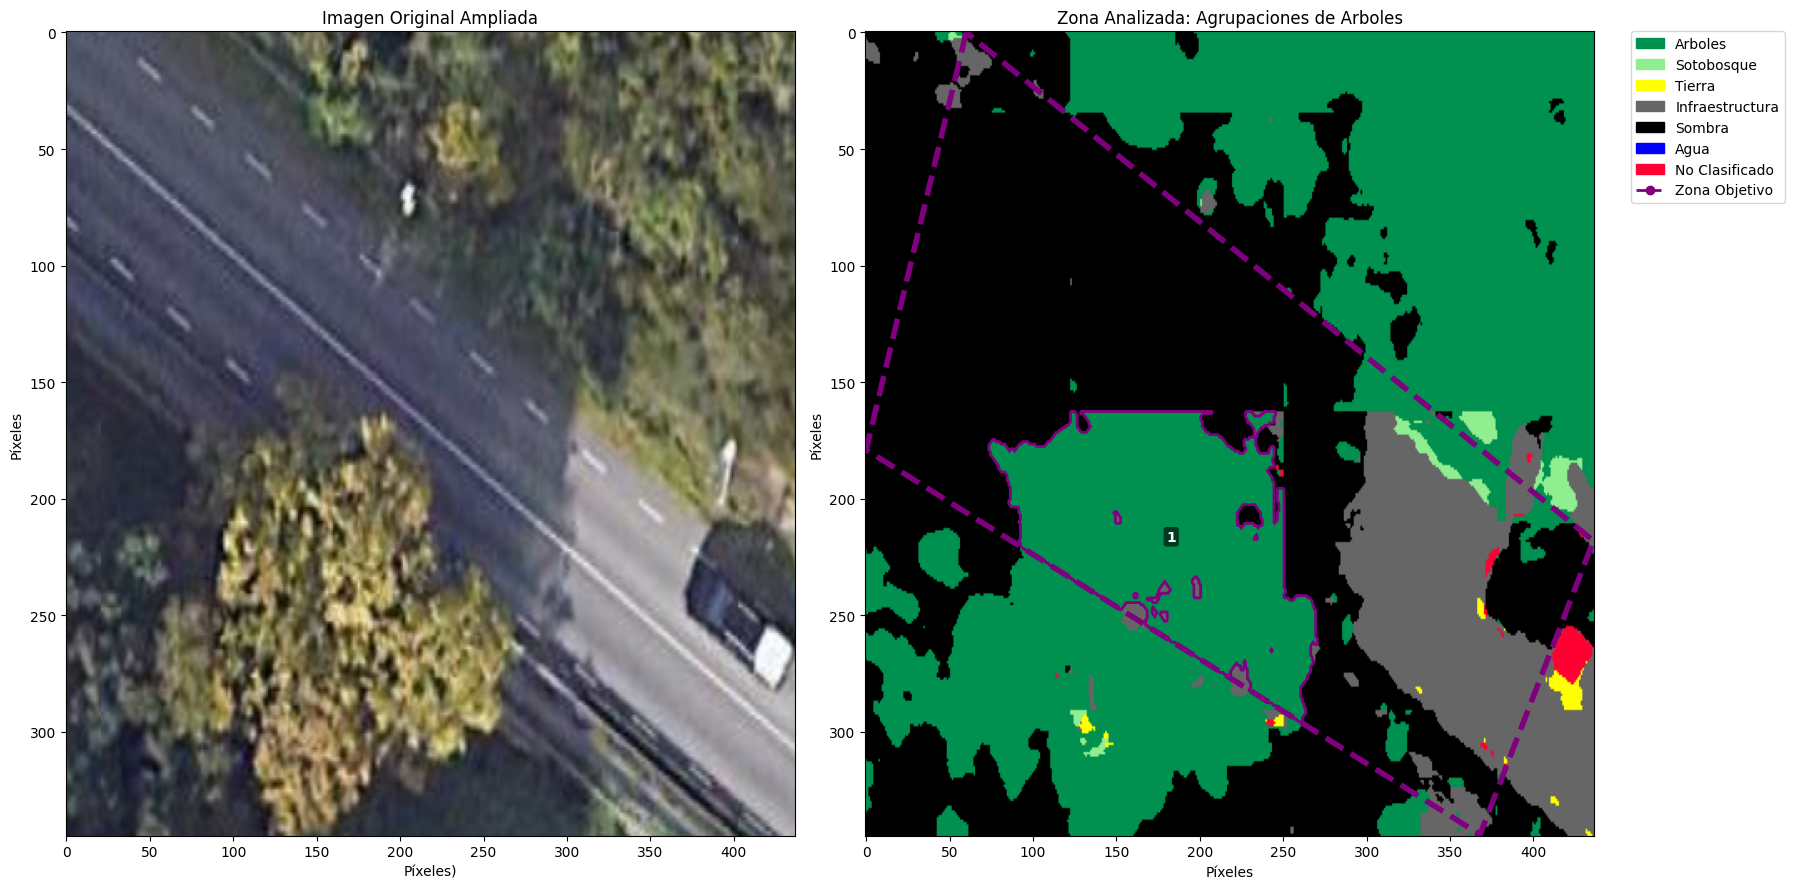

In [35]:
# Celda 9: Visualización Comparativa (Imagen Original Ampliada vs. Imagen Segmentada Ampliada)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import rasterio
import numpy as np
from skimage import measure
from scipy import ndimage # Para calcular el centro de masa del texto

# --- Rutas de imágenes ---
original_image_path = 'OG_029.tif' # Ruta a la imagen original

# Asegurarse de que los resultados del análisis anterior estén disponibles
# Estas variables deberían venir de la ejecución de la Celda 5 y 8
if 'rect_coords_pixels' not in locals() or rect_coords_pixels is None:
    print("Error: Las coordenadas de la zona de interés (rect_coords_pixels) no están definidas.")
elif 'segmented_data' not in locals():
    print("Error: La imagen segmentada completa (segmented_data) no está disponible. Por favor, ejecuta la Celda 3 primero.")
elif 'all_valid_blobs_masks' not in locals():
    print("Error: Las máscaras de las agrupaciones (all_valid_blobs_masks) no están disponibles. Por favor, ejecuta la Celda 8 primero.")
elif 'polygon_coords_pixel_relative_to_subset' not in locals() or polygon_coords_pixel_relative_to_subset is None:
    print("Error: Las coordenadas del polígono de entrada relativas (polygon_coords_pixel_relative_to_subset) no están disponibles.")
else:
    row_start, col_start, row_end, col_end = rect_coords_pixels

    # --- Cargar y extraer la zona de interés de la IMAGEN ORIGINAL ---
    try:
        with rasterio.open(original_image_path) as src_original:
            # Leer todas las bandas de la imagen original
            original_data_full = src_original.read()
            
            # Extraer la sub-región de interés para todas las bandas
            if original_data_full.ndim == 3: # Asumiendo RGB (num_bands, rows, cols)
                zoomed_original_data = original_data_full[:, row_start:row_end, col_start:col_end]
                # Reorganizar a (rows, cols, num_bands) para imshow si es RGB
                zoomed_original_data = np.transpose(zoomed_original_data, (1, 2, 0))
            elif original_data_full.ndim == 2: # Si es una imagen en escala de grises (rows, cols)
                zoomed_original_data = original_data_full[row_start:row_end, col_start:col_end]
            elif original_data_full.ndim == 3 and original_data_full.shape[0] == 1: # Si es (1, H, W)
                zoomed_original_data = original_data_full.squeeze()[row_start:row_end, col_start:col_end]
            else:
                print("Advertencia: Formato de imagen original no esperado. Mostrando la primera banda.")
                zoomed_original_data = original_data_full[0, row_start:row_end, col_start:col_end]


    except rasterio.RasterioIOError:
        print(f"Error: No se pudo abrir la imagen original '{original_image_path}'")
        exit()
    except Exception as e:
        print(f"Ocurrió un error al cargar la imagen original: {e}")
        exit()

    zoomed_segmented_data = segmented_data[row_start:row_end, col_start:col_end]

    fig, axes = plt.subplots(1, 2, figsize=(18, 9))
    # --- Subplot 1: Imagen Original Ampliada ---
    axes[0].imshow(zoomed_original_data)
    axes[0].set_title('Imagen Original Ampliada')
    axes[0].set_xlabel('Píxeles)')
    axes[0].set_ylabel('Píxeles')
    axes[0].set_aspect('auto') # Permitir que el aspecto se ajuste si las resoluciones son diferentes

    # --- Subplot 2: Imagen Segmentada Ampliada (con polígonos y números) ---
    axes[1].imshow(zoomed_segmented_data, cmap=cmap, vmin=0, vmax=len(colors_for_cmap) - 1)
    axes[1].set_title(f'Zona Analizada: Agrupaciones de {example_target_class_name}')
    axes[1].set_xlabel('Píxeles')
    axes[1].set_ylabel('Píxeles')
    axes[1].set_aspect('auto')

    #Diseño del polígono 
    input_polygon_patch_zoom = mpatches.Polygon(
        polygon_coords_pixel_relative_to_subset[:, ::-1], # Invertir a (col, row)
        closed=True,
        edgecolor='purple' if is_present else 'blue', # Color según si hay presencia o no
        facecolor='none',
        linewidth=4,
        linestyle='--'
    )
    axes[1].add_patch(input_polygon_patch_zoom)
    if all_valid_blobs_masks:
        for i, blob_mask in enumerate(all_valid_blobs_masks):
            contours_zoomed = measure.find_contours(blob_mask, level=0.5)
            
            # Calcular el centroide para el texto
            center_of_mass_relative = ndimage.center_of_mass(blob_mask)
            text_y, text_x = center_of_mass_relative[0], center_of_mass_relative[1]
            
            for contour in contours_zoomed:
                polygon_coords_x_zoom = contour[:, 1]
                polygon_coords_y_zoom = contour[:, 0]
                
                #HOTSPOTS DE LA AGRUPACIÓN
                polygon_zoom = mpatches.Polygon(
                    np.column_stack([polygon_coords_x_zoom, polygon_coords_y_zoom]),
                    closed=True,
                    edgecolor='purple', # Color verde brillante para los polígonos de las agrupaciones
                    facecolor='none',
                    linewidth=2,
                    linestyle='-'
                )
                axes[1].add_patch(polygon_zoom)
            
            # Añadir el número de la agrupación
            axes[1].text(
                text_x, text_y, str(i + 1),
                color='white',
                fontsize=10,
                fontweight='bold',
                ha='center',
                va='center',
                bbox=dict(facecolor='black', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2')
            )
    
    # Crear leyenda para el subplot segmentado
    legend_handles_segmented = list(patches) # Incluye las clases de la leyenda original
    
    input_polygon_legend_patch_segmented = mlines.Line2D(
        [], [],
        color='purple' if is_present else 'blue',
        marker='o',
        linestyle='--',
        linewidth=2,
        label='Zona Objetivo'
    )
    legend_handles_segmented.append(input_polygon_legend_patch_segmented)
    axes[1].legend(handles=legend_handles_segmented, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()